In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Importando Bibliotecas**

In [3]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Usando: {device}")

🖥️ Usando: cpu


#**Preparando os dados**

In [4]:

#Script para extrair notas e textos de reviews


def ler_docx(caminho_arquivo):

    try:
        resultado = subprocess.run(
            ['pandoc', caminho_arquivo, '-t', 'plain'],
            capture_output=True,
            text=True,
            check=True
        )
        return resultado.stdout
    except subprocess.CalledProcessError as e:
        print(f"Erro ao ler o arquivo: {e}")
        sys.exit(1)

def extrair_reviews(texto):
    """
    Extrai todas as reviews do texto usando regex
    Retorna uma lista de tuplas (texto_review, nota)
    """
    # Pattern para capturar
    pattern = r'(\d+)\s*/10\s*(.*?)\s*Helpful'

    # re.DOTALL faz o . capturar também quebras de linha
    matches = re.findall(pattern, texto, re.DOTALL)

    reviews = []
    for match in matches:
        nota = int(match[0])
        texto_review = match[1].strip()
        # Limpa espaços extras e quebras de linha múltiplas
        texto_review = re.sub(r'\n{3,}', '\n\n', texto_review)
        reviews.append((texto_review, nota))

    return reviews

def criar_dataframe(reviews):
    """
    Cria um DataFrame pandas com as colunas, id, X (texto) e Y (nota)
    """
    df = pd.DataFrame(reviews, columns=['X', 'Y'])
    df.insert(0, 'id', range(1, len(df) + 1))
    return df

def main():

    caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/projeto 1 - data set.docx'

    # Ler o arquivo docx
    texto_completo = ler_docx(caminho_arquivo)

    # Extrair as reviews
    reviews = extrair_reviews(texto_completo)

    if not reviews:
        print("⚠️  Nenhuma review encontrada no formato esperado!")
        print("    Formato esperado: NOTA/10 ... TEXTO ... Helpful")
        return None

    # Criar DataFrame
    df = criar_dataframe(reviews)

    # Exibir resultados
    print(f"\n✅ {len(df)} reviews extraídas com sucesso!\n")
    print("=" * 60)
    print("RESUMO DOS DADOS:")
    print("=" * 60)
    print(f"\nDistribuição das notas:")
    print(df['Y'].value_counts().sort_index())
    print(f"\nEstatísticas:")
    print(df['Y'].describe())

    # Mostrar preview
    print("\n" + "=" * 60)
    print("PREVIEW DAS PRIMEIRAS 3 REVIEWS:")
    print("=" * 60)
    for i, row in df.head(3).iterrows():
        print(f"\n--- Review {i+1} ---")
        print(f"Nota (Y): {row['Y']}")
        print(f"Texto (X): {row['X'][:200]}..." if len(row['X']) > 200 else f"Texto (X): {row['X']}")

    # Salvar como CSV
    output_path = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/reviews_extraidas.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Dados salvos em: {output_path}")

    return df

if __name__ == "__main__":
    df = main()


✅ 544 reviews extraídas com sucesso!

RESUMO DOS DADOS:

Distribuição das notas:
Y
1     111
2      56
3      58
4      50
5      63
6      59
7      55
8      36
9      22
10     34
Name: count, dtype: int64

Estatísticas:
count    544.000000
mean       4.553309
std        2.800439
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       10.000000
Name: Y, dtype: float64

PREVIEW DAS PRIMEIRAS 3 REVIEWS:

--- Review 1 ---
Nota (Y): 6
Texto (X): Confusing and Confused Movie

Nicole Kidman is giving a performance in "Babygirl" that no doubt many
people will be calling "brave," mostly because it suggests that women
over the age of 50 (gasp!) li...

--- Review 2 ---
Nota (Y): 6
Texto (X): Spoilers: Took me a couple of days to understand the ending and the
twist

--- Review 3 ---
Nota (Y): 5
Texto (X): This Baby Has Some Growing Up To Do

A lot has been said about Babygirl, mostly involving Kidman's
performance. The remainder of chatter has been about the 

#**Separando os dados em Training e Test sets**

In [5]:

# Carrega o CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/reviews_extraidas.csv')

# 1-5 = Negativo (0)
# 6-10 = Positivo (1)
def categorizar(nota):
    if nota <= 5:
        return 0  # Negativo
    else:
        return 1  # Positivo

df['Y_categoria'] = df['Y'].apply(categorizar)

# Separa X (texto) e Y (CATEGORIA, não a nota original!)
X = df['X']
Y = df['Y_categoria']

print("=" * 50)
print("DISTRIBUIÇÃO DAS 3 CLASSES")
print("=" * 50)
print(f"Negativo (0): {(Y == 0).sum()}")
print(f"Positivo (1): {(Y == 1).sum()}")


# Divide em treino (80%) e teste (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# Mostra os resultados
print("\n" + "=" * 50)
print("DIVISÃO DOS DADOS")
print("=" * 50)
print(f"\nTotal de reviews: {len(df)}")
print(f"Training set: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:")
print("=" * 50)
print(Y_train.value_counts().sort_index())

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TEST SET:")
print("=" * 50)
print(Y_test.value_counts().sort_index())

DISTRIBUIÇÃO DAS 3 CLASSES
Negativo (0): 338
Positivo (1): 206

DIVISÃO DOS DADOS

Total de reviews: 544
Training set: 435 (80.0%)
Test set: 109 (20.0%)

DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:
Y_categoria
0    270
1    165
Name: count, dtype: int64

DISTRIBUIÇÃO DAS CLASSES NO TEST SET:
Y_categoria
0    68
1    41
Name: count, dtype: int64


#**BERT**

#**Preparar os dados para o BERT**

In [6]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, textos, labels, tokenizer, max_length=256):
        self.textos = textos
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.textos)

    def __getitem__(self, idx):
        texto = str(self.textos.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            texto,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Carregar tokenizer do BERT
print("🔄 Carregando tokenizer BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("✅ Tokenizer carregado!")

# Criar datasets
train_dataset = ReviewDataset(X_train, Y_train, tokenizer)
test_dataset = ReviewDataset(X_test, Y_test, tokenizer)

print(f"✅ Dataset treino: {len(train_dataset)} amostras")
print(f"✅ Dataset teste: {len(test_dataset)} amostras")

🔄 Carregando tokenizer BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer carregado!
✅ Dataset treino: 435 amostras
✅ Dataset teste: 109 amostras


#**Carregar modelo BERT pré-treinado**

In [7]:
print("🔄 Carregando modelo BERT...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Binário: Negativo (0) e Positivo (1)
)
model.to(device)
print("✅ Modelo BERT carregado!")

🔄 Carregando modelo BERT...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Modelo BERT carregado!


#**Configurar e treinar**

In [8]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Configurações de treino
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Treinar
print("🔄 Treinando BERT (pode demorar alguns minutos)...")
trainer.train()
print("✅ Treinamento concluído!")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


🔄 Treinando BERT (pode demorar alguns minutos)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.715246,0.666252,0.614679,0.618254
2,0.489236,0.433911,0.788991,0.792185


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.715246,0.666252,0.614679,0.618254
2,0.489236,0.433911,0.788991,0.792185
3,0.324102,0.528796,0.770642,0.773439


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

✅ Treinamento concluído!


#**AVALIAR RESULTADOS**

In [10]:
# Predições
predictions = trainer.predict(test_dataset)
Y_pred_bert = predictions.predictions.argmax(-1)

# Resultados
print("\n" + "=" * 60)
print("📈 RESULTADOS - BERT (Binário)")
print("=" * 60)

accuracy = accuracy_score(Y_test, Y_pred_bert)
f1_macro = f1_score(Y_test, Y_pred_bert, average='macro')
f1_weighted = f1_score(Y_test, Y_pred_bert, average='weighted')

print(f"\n🎯 Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 F1-Score (macro): {f1_macro:.4f}")
print(f"🎯 F1-Score (weighted): {f1_weighted:.4f}")

print("\n📋 CLASSIFICATION REPORT")
print(classification_report(Y_test, Y_pred_bert, target_names=['Negativo', 'Positivo']))

# Matriz de Confusão
cm = confusion_matrix(Y_test, Y_pred_bert)
print("📊 MATRIZ DE CONFUSÃO")
print(cm)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📈 RESULTADOS - BERT (Binário)

🎯 Acurácia: 0.7890 (78.90%)
🎯 F1-Score (macro): 0.7843
🎯 F1-Score (weighted): 0.7922

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negativo       0.89      0.75      0.82        68
    Positivo       0.67      0.85      0.75        41

    accuracy                           0.79       109
   macro avg       0.78      0.80      0.78       109
weighted avg       0.81      0.79      0.79       109

📊 MATRIZ DE CONFUSÃO
[[51 17]
 [ 6 35]]


#**VISUALIZAÇÃO**

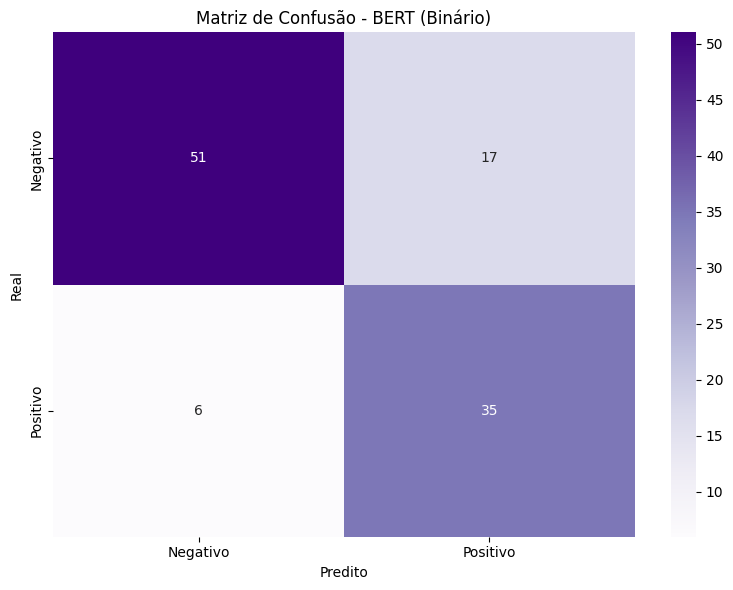

In [11]:
# Visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - BERT (Binário)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [12]:
# Testar novas reviews com BERT
novas_reviews = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either."
]

classe_nome = {0: 'Negativo', 1: 'Positivo'}

print("=" * 60)
print("🔮 PREDIÇÕES - BERT")
print("=" * 60)

for review in novas_reviews:
    # Tokenizar
    inputs = tokenizer(
        review,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='pt'
    )

    # Mover para o device (CPU/GPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predição
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

        # Probabilidades (softmax)
        probs = torch.softmax(logits, dim=1)[0]
        prob_neg = probs[0].item()
        prob_pos = probs[1].item()

    print(f"\nReview: {review}")
    print(f"Probabilidades: Negativo={prob_neg:.2%} | Positivo={prob_pos:.2%}")
    print(f"Classe predita: {pred} ({classe_nome[pred]})")

🔮 PREDIÇÕES - BERT

Review: This movie was absolutely amazing! I loved every moment of it.
Probabilidades: Negativo=29.78% | Positivo=70.22%
Classe predita: 1 (Positivo)

Review: Terrible film. Waste of time and money. Do not watch.
Probabilidades: Negativo=94.73% | Positivo=5.27%
Classe predita: 0 (Negativo)

Review: It was okay, nothing special but not bad either.
Probabilidades: Negativo=35.24% | Positivo=64.76%
Classe predita: 1 (Positivo)
